In [1]:
import numpy as np
import json
import pandas as pd
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score
from sklearn.model_selection import KFold, cross_validate


In [2]:
embedding = np.load('embeddingsFunctions.npy')

In [3]:
embedding

array([[  -9.491208 ,   -4.293011 ,    6.5573378, ...,   -9.496958 ,
         -14.024918 ,   18.459995 ],
       [ -50.30785  ,   -5.665318 ,   41.92286  , ..., -102.127014 ,
         -67.21787  ,   81.95627  ],
       [ -17.796965 ,   -2.0593688,   14.956287 , ...,  -27.786087 ,
         -27.090714 ,   32.711857 ],
       ...,
       [ -40.76267  ,  -23.654156 ,   33.958576 , ...,  -75.81511  ,
         -70.37083  ,   77.61262  ],
       [ -37.414135 ,    5.1769733,   33.312157 , ...,  -47.122395 ,
         -52.825745 ,   89.67482  ],
       [ -45.545326 ,   -9.823501 ,   31.930258 , ...,  -72.07044  ,
         -66.57554  ,   84.67709  ]], dtype=float32)

In [4]:
df_embeding = pd.DataFrame(embedding)

In [5]:
df_embeding.head()

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-9.491208,-4.293011,6.557338,2.324635,-4.110653,-18.421602,3.545898,4.939705,13.935108,9.644430,...,14.129484,-6.404897,-8.465531,17.403751,-0.149862,10.612970,27.941216,-9.496958,-14.024918,18.459995
1,-50.307850,-5.665318,41.922859,5.622422,-46.825539,-45.153545,12.420534,27.428173,36.160347,51.240234,...,93.209892,-4.304795,-60.084942,80.325668,-42.661388,27.314810,90.997803,-102.127014,-67.217873,81.956268
2,-17.796965,-2.059369,14.956287,1.161129,-4.123035,-18.293316,8.428608,9.345697,17.435543,19.581253,...,21.622833,-11.094868,-22.534601,35.298897,-10.162546,11.461794,29.437634,-27.786087,-27.090714,32.711857
3,-15.114033,0.189284,13.828127,10.244881,-25.291935,-8.200372,-1.575973,11.206701,30.824116,18.168877,...,21.261433,-13.285295,-27.819294,30.270485,-17.241535,13.737978,44.297356,-18.110889,-19.301985,41.015862
4,-47.105614,-1.536545,41.922962,30.267897,-50.127007,-74.078018,8.260659,29.822273,54.405003,56.674427,...,73.100281,-16.279345,-63.755733,93.611946,-27.551670,39.698051,130.065796,-82.670166,-69.430428,99.613213


In [6]:
# Check the platform
if os.name == 'nt':  # Windows
    file_path = "Big-Vul-dataset\data.json"
else:  # Unix/Linux/MacOS
    file_path = "Big-Vul-dataset/data.json"

# Load JSON data
with open(file_path, 'r') as file:
    df_bigVul = json.load(file)

# Convert JSON to DataFrame
df_bigVulPandas = pd.DataFrame(df_bigVul)

# Data Preprocessing

We concatinate the into single column in dataframe

In [7]:
df_new = pd.DataFrame()
df_new['feature'] = df_embeding.apply(lambda row: row.values.tolist(), axis=1)

In [8]:
df_new['vul'] = df_bigVulPandas['vul']

## Data exploration

In this part we will explore the data to understand the distribution of the target variable

In [9]:
#Data exploration
df_new['vul'].value_counts()

vul
0    177736
1      8794
Name: count, dtype: int64

In [10]:
df_bigVulPandas

,code,vul,flaw_line_no,bigvul_id
0,static inline void clgi(void)\n{\n asm volati...,0,[],37737
1,"int nfs_open(struct inode *inode, struct file ...",0,[],22804
2,void RenderWidgetHostViewAura::OnCompositingSt...,0,[],132986
3,bool Contains(const std::vector<string16>& war...,0,[],122089
4,static int media_not_present(struct scsi_disk ...,0,[],94376
...,...,...,...,...
186525,static void Rp_test(js_State *J)\n {\n js_Re...,1,"[10, 17, 21, 22, 23, 24, 25, 27, 28, 29]",182868
186526,static void __exit ipgre_fini(void)\n {\n r...,1,[5],179055
186527,static void bt_tags_for_each(struct blk_mq_tag...,1,"[11, 12, 13, 14, 15, 17]",182628
186528,void SupervisedUserService::InitSync(const st...,1,"[4, 5]",186544


In [11]:
vul_counts = df_bigVulPandas['vul'].value_counts()
print(vul_counts)

vul
0    177736
1      8794
Name: count, dtype: int64


In [12]:
df_bigVulPandas.shape

(186530, 4)

### Some helper functions

This part contains some helper functions that will be used in the following sections.

First function selects a random sample of non-vulnerable functions from the DataFrame is used to always select random data and prevent a bias in the model towards a favorable sample of the data.

The second one is specifically written for hyperparameter testing. It selects the first 8794 elements of the DataFrame, which is the same number of vulnerable functions in the dataset. We need this in order to make sure, that the sample does not introduce additional variance. This function is used to test the model's performance when the data is not randomly selected.

In [13]:
def select_random_non_vulnerable(df, num_samples=8794):
    # Filter the DataFrame to only include non-vulnerable functions
    non_vulnerable = df[df['vul'] == 0]

    # Select a random sample of non-vulnerable functions
    random_sample = non_vulnerable.sample(n=num_samples, random_state=42)

    return random_sample

In [14]:
def random_or_first(random=False, df_new=df_new):
    if random:
        # Select random non-vulnerable functions
        df_first = select_random_non_vulnerable(df_new)
    else:
        # Select the first 8794 elements
        df_first = df_new.iloc[:8794]

    return df_first

In [15]:
# Select random or the first (for hyperparameter testing) non-vulnerable functions
df_first = random_or_first(random=True)

# Select the last 8794 elements
df_last = df_new.iloc[-8794:]

# Concatenate the first and last elements into the same DataFrame
df_combined = pd.concat([df_first, df_last])

In [16]:
df_combined

,feature,vul
77157,"[-50.95094680786133, -8.486884117126465, 26.37...",0
27855,"[-19.914142608642578, -0.011556863784790039, 1...",0
154615,"[-49.319637298583984, -3.380096912384033, 43.4...",0
11361,"[-61.51172637939453, -17.690244674682617, 33.3...",0
47272,"[-47.55849075317383, 14.30803108215332, 51.174...",0
...,...,...
186525,"[-46.34038543701172, -17.838274002075195, 42.8...",1
186526,"[-42.507198333740234, 8.088626861572266, 32.04...",1
186527,"[-40.76266860961914, -23.654155731201172, 33.9...",1
186528,"[-37.41413497924805, 5.176973342895508, 33.312...",1


## Train test splitting

In this part we will split the data into training and testing sets

With argument stratify=y we make sure that the train and test datasets have the same proportion of classes (0s and 1s) as the input dataset

In [17]:
# Assuming df_combined is your DataFrame and 'vul' is your target variable
y = df_combined['vul']
X = df_combined.drop('vul', axis=1)

# stratify=y will make sure that the train and test datasets have the same proportion of classes (0s and 1s) as the input dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)#%%



## Training the model

In this part we will train the RandomForestModel using the training data

In [18]:
rf = RandomForestClassifier(max_depth=40, n_estimators=200, max_features='sqrt', random_state=42)
# Convert pandas Series of lists to numpy array
X_train_array = np.vstack(X_train['feature'])

# Now we can fit the RandomForestClassifier with the numpy arrays
rf.fit(X_train_array, y_train)

RandomForestClassifier(max_depth=40, n_estimators=200, random_state=42)

In [19]:
X_test_array = np.vstack(X_test['feature'])
score=rf.score(X_test_array,y_test)
score

0.7126208072768618

## Hyperparameter tuning

In this part we will use GridSearchCV to find the best hyperparameters for the RandomForestModel

*Uncomment to run -> 1 run with around 17500 samples lasts approx. 20Min on laptop CPU*

In [20]:
# # Define the hyperparameters grid
# param_grid = {
#     'n_estimators': [10, 50, 100, 200],
#     'max_depth': [None, 10, 20, 30, 40, 50],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['auto', 'sqrt']
# }
# 
# # Initialize the GridSearchCV object
# grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='accuracy', verbose=2, n_jobs=-1)
# 
# # Fit the GridSearchCV object to the data
# grid_search.fit(X, y)
# 
# # Get the best parameters and the best score
# best_params = grid_search.best_params_
# best_score = grid_search.best_score_
# 
# print(f"Best parameters: {best_params}")
# print(f"Best score: {best_score}")

# Evaluating the model

in this part we will evaluate the model using precision, recall and F1 score the test data

In [21]:
# Get the predictions
predictions = rf.predict(list(X_test['feature']))

# Print the classification report
report = classification_report(list(y_test), predictions)
print(report)

              precision    recall  f1-score   support

           0       0.72      0.70      0.71      1759
           1       0.71      0.73      0.72      1759

    accuracy                           0.71      3518
   macro avg       0.71      0.71      0.71      3518
weighted avg       0.71      0.71      0.71      3518



## ROC curve

In this part we will plot the ROC curve for the model

Optimal threshold value: 0.50875


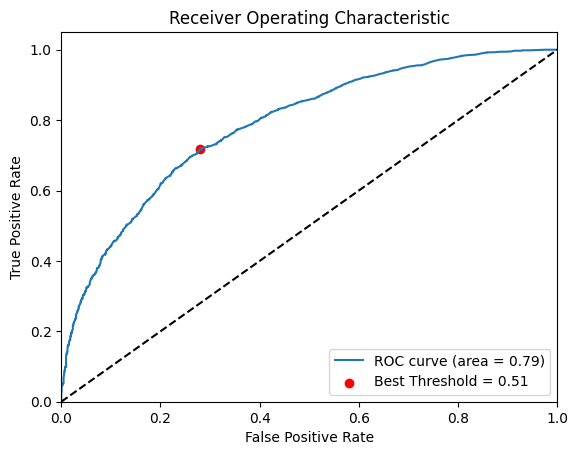

In [22]:
# Get the predictions
y_scores = rf.predict_proba(list(X_test['feature']))

# Compute ROC curve for the classifier
fpr, tpr, thresholds = roc_curve(list(y_test), y_scores[:, 1])

# Compute the optimal threshold
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal threshold value: {optimal_threshold}")

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc(fpr, tpr))
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], marker='o', color='red', label='Best Threshold = %0.2f' % optimal_threshold)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## K-Fold Cross-validation

In this part we will perform k-fold cross-validation to evaluate the model and spot potential overfitting and underfitting and evaluate the model's performance based on different metrics

In [24]:
# Define dictionary with performance metrics
scoring = {'accuracy': 'accuracy',
           'precision': make_scorer(precision_score, average='weighted'),
           'recall': make_scorer(recall_score, average='weighted'),
           'f1_score': make_scorer(f1_score, average='weighted')}

X_array = np.vstack(X['feature'])
y_array = np.array(y)

# Initialize scores dictionary
scores = {metric: [] for metric in scoring.keys()}

# Compute metrics and append to scores dictionary
fold_scores = cross_validate(rf, X_array, y_array, cv=5, scoring=scoring, verbose=1)

### Calculate aggregated scores from cross-validation results ###

# Initialize an empty dictionary to store the aggregated values
aggregated_scores = {}

# Iterate over each metric in the fold_scores dictionary
for metric_name in fold_scores.keys():
    # Skip non-score keys
    if not metric_name.startswith('test_'):
        continue

    # Calculate the mean and standard deviation of the metric
    metric_mean = np.mean(fold_scores[metric_name])
    metric_std = np.std(fold_scores[metric_name])

    # Store the aggregated values in the aggregated_scores dictionary
    aggregated_scores[metric_name] = {
        'mean': metric_mean,
        'std': metric_std
    }

# Print the aggregated_scores dictionary
for metric, values in aggregated_scores.items():
    print(f"{metric}: mean = {values['mean']}, std = {values['std']}")



test_accuracy: mean = 0.6953609391434732, std = 0.004988748260533128
test_precision: mean = 0.6961333658151964, std = 0.004954903722502556
test_recall: mean = 0.6953609391434732, std = 0.004988748260533128
test_f1_score: mean = 0.6950596217904067, std = 0.0050156683019012905
